##Imports - Downloads

In [19]:
# for reading csv into dataframes
import pandas as pd

# for neural networks, tensors, dataloader (pytorch)
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# for score metrics (precision, recall and f1)
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# for data cleaning/preprocessing
import re
import string
import nltk

# download stop words from nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

# for the learning curves
import matplotlib.pyplot as plt

# for the roc curves
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# for seeding - so that we get same results every time we run the notebook
import random
seed = 1234
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
os.environ['PYTHONHASHSEED'] = str(seed)

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# download pre-trained word embeddings from GloVe
!wget https://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2022-01-17 07:41:03--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-01-17 07:41:04--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.01MB/s    in 2m 40s  

2022-01-17 07:43:44 (5.13 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: 

##Useful Functions

In [20]:
def data_cleaning(text):
  """ function that performs necessary and useful text cleaning """
  # lower case text
  text = text.lower()
  # remove unicode characters unreadable in ascii
  text = text.encode('ascii', 'ignore').decode()
  # Remove mentions
  text = re.sub("@\S+", " ", text)
  # Remove URL
  text = re.sub("https*\S+", " ", text)
  # Remove hashtags
  #text = re.sub("#\S+", " ", text)
  # Remove the large spaces/tabs
  text = re.sub('\s{2,}', " ", text)
  # Remove the ' character
  text = re.sub("\'\w+", '', text)
  # Remove punctuation
  text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
  # Remove numbers
  text = re.sub(r'\w*\d+\w*', '', text)
  # Remove stop words
  text = ' '.join([word for word in text.split(' ') if word not in stop_words])
  return text

def sentences_to_sequences(sentences, word_index_dict, max_length):
  """ function that converts a list of sentences to a tensor of integer sequences, sequences are produced from vectorization of sentences """
  x = np.zeros((len(sentences), max_length)).astype(np.int)
  index = 0
  for sentence in sentences:
    sequence = np.zeros(max_length).astype(np.int) # initialize sequence
    tokenized_sentence = sentence.split()          # tokenize each sentence to its words
    sequence_indices = []
    for word in tokenized_sentence:
      if word in word_index_dict:               # check if word of sentence is present in GloVe word dictionary
        sequence_indices.append(word_index_dict[word])  # if it is, add its index to the sequence
      else:
        sequence_indices.append(word_index_dict[''])    # if it is not, add index corresponding to unknown word
    length = min(max_length, len(sequence_indices))
    sequence[:length] = np.array(sequence_indices[:length])
    x[index] = sequence
    index += 1
  
  return torch.from_numpy(x)  # return the tensor from converting numpy x to tensor

def print_scores(y_true, y_pred, train_set):
  """ function that prints classification scores """
  if train_set:
    print("Classification scores for training set:\n")
  else:
    print("Classification scores for validation/test set:\n")
  
  # print weighted average scores
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  score = f1_score(y_true, y_pred, average='weighted')
  print("Weighted average Precision = ", precision)
  print("Weighted average Recall    = ", recall)
  print("Weighted average F1 score  = ", score)
  print("\n")

  # print scores for each class
  precision = precision_score(y_true, y_pred, average=None)
  recall = recall_score(y_true, y_pred, average=None)
  score = f1_score(y_true, y_pred, average=None)

  for i in range(score.shape[0]):
    print("Class ", i, " Precision = ", precision[i])
    print("Class ", i, " Recall    = ", recall[i])
    print("Class ", i, " F1 score  = ", score[i])
    print("\n")

  print("\n")

def make_subplot(epochs, train_scores, val_scores, title_1, train_losses, val_losses, title_2):
  """ make subplot of train epochs in relation to train and validation scores and losses (plot the learning curves) """
  # plot learning curves
  print("\n")
  fig = plt.figure(figsize=(16, 6), dpi=120)
  ax1 = fig.add_subplot(1,2,1)
  plt.plot(epochs, train_scores, label="Training Score")
  plt.plot(epochs, val_scores, label="Validation/Test Score")
  plt.xlabel("Epoch")
  plt.ylabel("Classification F1 Score")
  plt.legend()
  plt.title(title_1)

  ax2 = fig.add_subplot(1,2,2)
  plt.plot(epochs, train_losses, label="Training Loss")
  plt.plot(epochs, val_losses, label="Validation/Test Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Cross-Entropy Loss")
  plt.legend()
  plt.title(title_2)

  plt.show()

def plot_roc_curve(y_true, y_pred):
  """ plots roc curve """
  # Binarize the y_true, y_pred to form one hot vectors of size (size of validation set, #classes)
  y_test = label_binarize(y_true, classes=[0, 1, 2])
  #y_score = label_binarize(y_pred, classes=[0, 1, 2])
  y_score = y_pred
  n_classes = 3

  # Compute ROC curve and ROC area for each class
  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i in range(n_classes):
      fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
      roc_auc[i] = auc(fpr[i], tpr[i])

  # Compute micro-average ROC curve and ROC area
  fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
  roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

  # Plot ROC curve
  fig = plt.figure(figsize=(8, 6), dpi=80)
  plt.plot(fpr["micro"], tpr["micro"],
          label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]))
  
  for i in range(n_classes):
      plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                    ''.format(i, roc_auc[i]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for all classes')
  plt.legend(loc="lower right")
  plt.show()

def model_results(model, x_train, y_train, x_val, y_val, epochs, train_scores, val_scores, train_losses, val_losses):
  """ prints model's results (classification scores, learning curves, roc curves) """
  # Print f1, precision, recall score for final model on training set
  model.eval()
  y_train_pred = model(x_train)
  probs = F.softmax(y_train_pred, dim=1)
  y_train_label_pred = probs.argmax(dim=1)
  print_scores(y_train, y_train_label_pred, True)
  
  #Print f1, precision, recall score for final model on test/validation set
  y_val_pred = model(x_val)
  y_probs = F.softmax(y_val_pred, dim=1)
  y_val_label_pred = y_probs.argmax(dim=1)
  print_scores(y_val, y_val_label_pred, False)

  # Print Learning Curve
  make_subplot(epochs, train_scores, val_scores, "Classification Score Learning Curve", train_losses, val_losses, "Loss Learning Curve")

  # Print Roc Curve
  plot_roc_curve(y_val, y_probs.detach().numpy())

def execute_training(model, loss_func, optimizer, batch_size, num_epochs, clip_grad=True, stop_early=True):
  """ function that trains the model in bathes of batch_size, for num_epochs, using given loss function, optimizer
      returns the train_losses, val_losses, train_scores, val_scores and the final trained model
      clip_grad : Flag that indicates if gradient clipping will be used (default is True)
      stop_early : Flag that indicates if early stopping regularization will be used (default is True) """

  #Initialize dataloader
  dataset = torch.utils.data.TensorDataset(x_train, y_train)
  dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
  
  #Initialize lists we care about
  train_losses = []
  val_losses = []
  train_scores = []
  val_scores = []

  # for early stopping
  min_val_loss = np.Inf   # keeps track of minimum validation loss thus far
  epochs_no_improve = 0   # keeps track of number of consecutive epochs where validation loss did not improve over minimum validation loss
  epoch_tolerance = 3     # if validation loss does not improve over 3 consecutive epochs, we stop training (early stopping)
  epochs_count = 0  

  # run for number of epochs
  for epoch in range(num_epochs):
    batch_losses = []
    batch_scores = []
    # training the model for current epoch
    model.train()
    for x_batch, y_batch in dataloader:
      #Delete previously stored gradients
      optimizer.zero_grad()
      # perform forward pass on current batch
      y_pred = model(x_batch)
      # calculate the loss of current batch
      loss = loss_func(y_pred, y_batch)
      # append the loss value
      batch_losses.append(loss.item())
      # apply softmax on raw logits to get softmax class scores for current batch
      probs = F.softmax(y_pred, dim=1)
      # apply argmax on softmax scores to get predicted labels for current batch
      y_label_pred = probs.argmax(dim=1)
      # calculate and append the f1 score value of current batch
      batch_scores.append(f1_score(y_batch, y_label_pred, average='weighted'))
      #Perform backpropagation starting from the loss calculated in this epoch
      loss.backward()

      if clip_grad is True:
        # Perform gradient clippint with threshold of 2.0
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0, norm_type=2)
      
      #Update model's weights based on the gradients calculated during backprop
      optimizer.step()
    
    # append average training loss for epoch
    train_losses.append(sum(batch_losses)/len(dataloader))
    # append average training score for epoch
    train_scores.append(sum(batch_scores)/len(dataloader))
    # compute and append training loss/score for validation/test set for this epoch
    model.eval()
    y_val_pred = model(x_val)
    val_loss = (loss_func(y_val_pred, y_val)).item()
    val_losses.append(val_loss)
    y_probs = F.softmax(y_val_pred, dim=1)
    y_val_label_pred = y_probs.argmax(dim=1)
    val_scores.append(f1_score(y_val, y_val_label_pred, average='weighted'))
    string = f'\rEpoch {epoch+1}/{num_epochs} -- Train Loss: {train_losses[-1]:0.4f} -- Validation Loss: {val_losses[-1]:0.4f}'
    print(string)

    epochs_count += 1
    # check for early stopping
    if stop_early is True:
      if val_loss < min_val_loss:
        epochs_no_improve = 0
        min_val_loss = val_loss
      else:
        epochs_no_improve += 1
      
      if (epochs_no_improve == epoch_tolerance):
        print('Early Stopping\n')
        break

  epochs = [epoch+1 for epoch in range(epochs_count)]
  return train_losses, val_losses, train_scores, val_scores, epochs, model

## Extract pre trained word embeddings from GloVe

In [21]:
# choosing one of GloVe pre trained corpus
vector_size = 200
datafile = "glove.6B.200d.txt"
# dictionary with words of pre-trained corpus as keys, corresponding embeddings as values
word_vector_dict = {}
# one additional empty word embedding for padding / unknown words
word_vector_dict[''] = np.zeros(vector_size, dtype='float')
# reading .txt file with word embeddings
with open(datafile, 'r', encoding="utf-8") as File: 
  for row in File:
    tokenized_row = row.split()          # tokenize each row of file
    word = tokenized_row[0]              # first token of row corresponds to a word of corpus
    word_vector = np.array(tokenized_row[1:]).astype(np.float)  # rest of tokenized_row is the vector corresponding to given word
    word_vector_dict[word] = word_vector            # save word and its vector in word_vector dictionary

len(word_vector_dict)

400001

## Create Embeddings Array , Word-2-Index dictionary

In [22]:
word_index_dict = {}
word_index = 0
number_of_words = len(word_vector_dict)
embeddings_array = np.zeros((number_of_words, vector_size))

for word in word_vector_dict:
  embeddings_array[word_index] = word_vector_dict[word]    # save word vector of word in embeddings array
  word_index_dict[word] = word_index  # save word in word_index dictionary
  word_index = word_index + 1

embeddings_array.shape

(400001, 200)

##Read and seperate training/validation sets

In [23]:
# MAIN FUNCTIONALITY

#Read the vaccine training set csv file
training_df = pd.read_csv("./sample_data/vaccine_train_set.csv")
#training_df.head()
#Read the vaccine validation set csv file
validation_df = pd.read_csv("./sample_data/vaccine_validation_set.csv")

#Fill NaN values
#data = data.fillna(0)
#Normalize values
#data = (data-data.mean())/data.std()

cleaning = True   # TODO : EXPERIMENT WITH/WITHOUT DATA CLEANING

if cleaning:
  # apply text cleaning for the tweets as pre-processing for the training set
  training_df['tweet'] = training_df['tweet'].apply(data_cleaning)
  # apply text cleaning for the tweets as pre-processing for the validation set
  validation_df['tweet'] = validation_df['tweet'].apply(data_cleaning)

#Seperate tweet and label columns into seperate dataframes for the training set
train_tweet_df = pd.DataFrame(training_df, columns=[training_df.columns[1]])
train_label_df = pd.DataFrame(training_df, columns=[training_df.columns[-1]])
#Seperate tweet and label columns into seperate dataframes for the validation set
val_tweet_df = pd.DataFrame(validation_df, columns=[training_df.columns[1]])
val_label_df = pd.DataFrame(validation_df, columns=[training_df.columns[-1]])

train_sentences = [x for x in train_tweet_df['tweet']]
val_sentences = [x for x in val_tweet_df['tweet']]
num_classes = 3

max = 0
for sentence in train_sentences:
  tokenized_sentence = sentence.split()          # tokenize each row of file
  if len(tokenized_sentence) > max:
    max = len(tokenized_sentence)

print("Maximum number of words in a sentence => ", max)


Maximum number of words in a sentence =>  39


## Convert tweet sentences to vectorized sequences

In [24]:
# define a fixed length for the encoding of each sentence (maximum number of words of sentence)
max_length = 25  # if a sentence has more than 25 words, it gets padded, otherwise it gets truncated 
#Save in tensors
# for training set
x_train = sentences_to_sequences(train_sentences, word_index_dict, max_length)
y_train = torch.tensor(train_label_df.values, dtype=torch.long)
y_train = y_train.view(-1)
# for validation set
x_val = sentences_to_sequences(val_sentences, word_index_dict, max_length)
y_val = torch.tensor(val_label_df.values, dtype=torch.long)
y_val = y_val.view(-1)

print(f"x shape: {x_train.shape}")
print(f"y shape: {y_train.shape}")

x shape: torch.Size([15976, 25])
y shape: torch.Size([15976])


## Bidirectional Stacked LSTM-GRU RNN wrapper class

In [25]:
class Classifier(nn.Module):
  """ Wrapper class for the classifier to be developed using LSTMs/GRUs """
  # dictionary for the type of cells to be used by classifier
  cells = {"LSTM" : nn.LSTM, "GRU" : nn.GRU}
  
  def __init__(self, cell_type, num_embeddings, embeddings_dim, embeddings_array, num_hidden , num_classes, num_layers, dropout_rate):
    """ constructor """
    # call to superclass constructor
    super().__init__()
    # embedding layer as input layer
    self.embedding = nn.Embedding(num_embeddings, embeddings_dim)
    self.embedding.weight = nn.Parameter(torch.tensor(embeddings_array, dtype=torch.float32))
    self.embedding.weight.requires_grad = False   # embeddings array weights are pre-trained from GloVe, so no training required
    # a stacked-bidirectional LSTM or GRU RNN follows 
    self.cell = Classifier.cells[cell_type](embeddings_dim, num_hidden, num_layers, bias=True, batch_first=True, dropout=dropout_rate, bidirectional=True)
    # linear output layer, outputs 3 scores, one for each class
    self.out = nn.Linear(2*num_hidden, num_classes)   # need 2 * num_hidden because it's bidirectional
    self.dropout = nn.Dropout(dropout_rate)
    self.num_layers = num_layers
    self.cell_type = cell_type

  def forward(self, x):
    """ performs a forward pass through model on input x, returns output """
    """ x must be a tensor of shape : (batch_size, sequence_length, input_size) """
    # input x first passes through the embedding layer : before x has shape (batch_size, sequence_length) after has shape (batch_size, sequence_length, embeddings_dim) which is the shape of x desired
    x = self.embedding(x)
    # embedded x then passes through the stacked-bidirectional LSTM/GRU
    if self.cell_type == 'LSTM':
      output, (hn, cn) = self.cell(x)  #output is a tensor of shape (batch_size, sequence_length, 2 * num_hidden)
    else:
      output, hn = self.cell(x)
    # output passes through the final linear output layer, to produce raw scores for each class
    output = self.out(output[:, -1, :]) # output from the last (rightmost) timestep/hidden state goes through linear layer
    # return raw scores for each class
    return output



##First Model : Single Layer LSTM

Epoch 1/10 -- Train Loss: 0.8828 -- Validation Loss: 0.7670
Epoch 2/10 -- Train Loss: 0.7414 -- Validation Loss: 0.7376
Epoch 3/10 -- Train Loss: 0.7075 -- Validation Loss: 0.7172
Epoch 4/10 -- Train Loss: 0.6672 -- Validation Loss: 0.7079
Epoch 5/10 -- Train Loss: 0.6284 -- Validation Loss: 0.7159
Epoch 6/10 -- Train Loss: 0.5974 -- Validation Loss: 0.6977
Epoch 7/10 -- Train Loss: 0.5712 -- Validation Loss: 0.7043
Epoch 8/10 -- Train Loss: 0.5401 -- Validation Loss: 0.7152
Epoch 9/10 -- Train Loss: 0.5112 -- Validation Loss: 0.7123
Early Stopping

Classification scores for training set:

Weighted average Precision =  0.8281432620237414
Weighted average Recall    =  0.824549323985979
Weighted average F1 score  =  0.823275051391398


Class  0  Precision =  0.9114124945895253
Class  0  Recall    =  0.8470099222311611
Class  0  F1 score  =  0.8780318298700396


Class  1  Precision =  0.7201201201201202
Class  1  Recall    =  0.578388808490111
Class  1  F1 score  =  0.6415195291599786


C

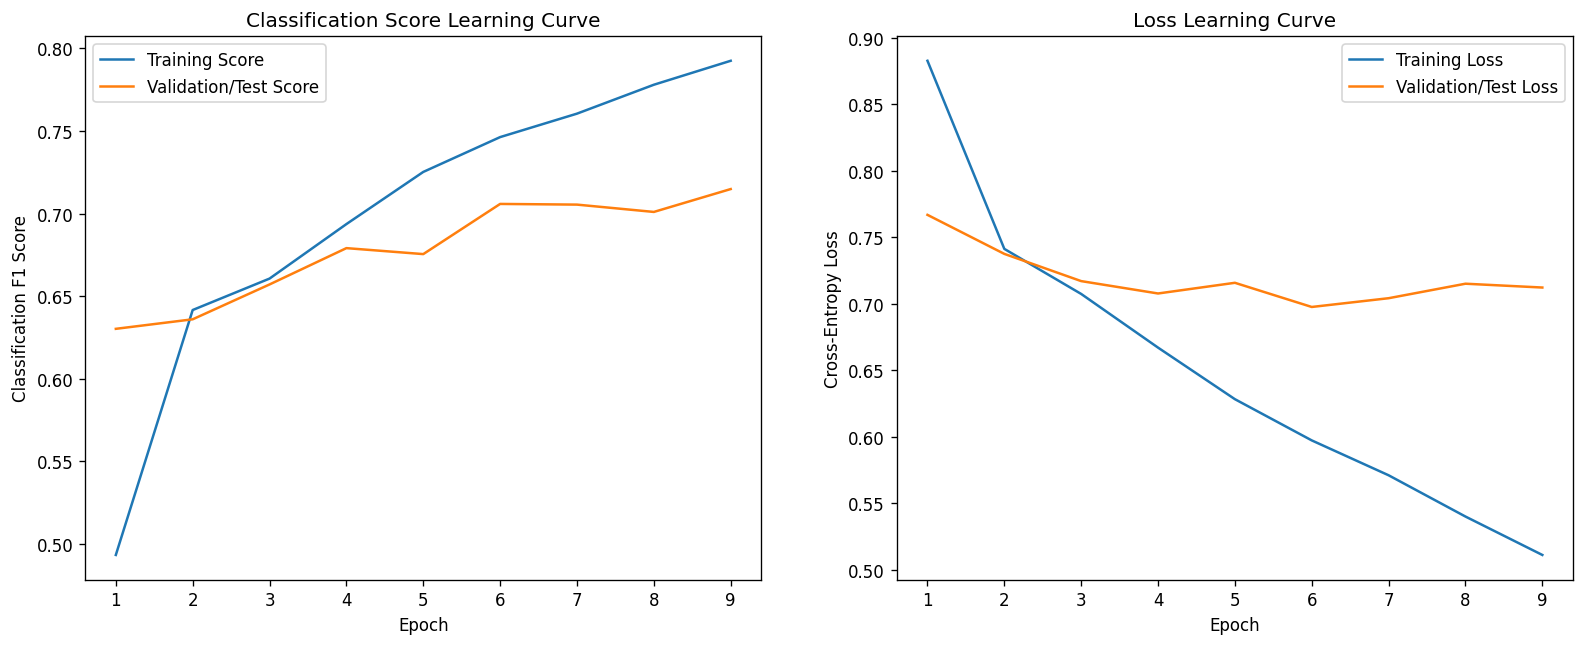

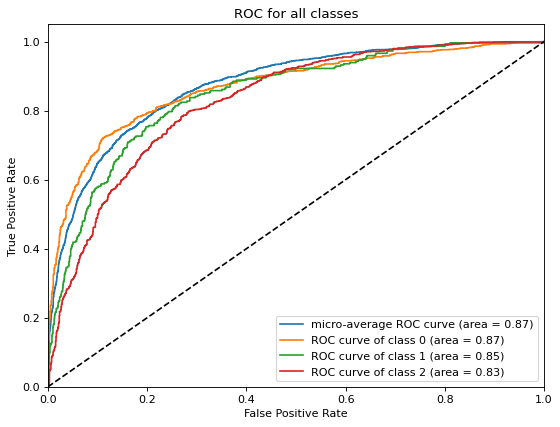

In [26]:
# hyperparameter tuning
num_hidden = 50     # number of features for each hidden cell
num_layers = 1      # number of stacked RNN layers
dropout_rate = 0.5  # dropout probability for regularization

model = Classifier('LSTM', number_of_words, vector_size, embeddings_array, num_hidden , num_classes, num_layers, dropout_rate) 
#print(model)

# more hyperparamenter tuning
batch_size = 64
num_epochs = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

# call training function for model, train for given num_epochs epochs
train_losses, val_losses, train_scores, val_scores, epochs, model = execute_training(model, loss_func, optimizer, batch_size, num_epochs)

# print model results
model_results(model, x_train, y_train, x_val, y_val, epochs, train_scores, val_scores, train_losses, val_losses)

## Second Model : Single Layer GRU

Epoch 1/10 -- Train Loss: 0.8809 -- Validation Loss: 0.7693
Epoch 2/10 -- Train Loss: 0.7417 -- Validation Loss: 0.7372
Epoch 3/10 -- Train Loss: 0.6973 -- Validation Loss: 0.6944
Epoch 4/10 -- Train Loss: 0.6529 -- Validation Loss: 0.6891
Epoch 5/10 -- Train Loss: 0.6187 -- Validation Loss: 0.6822
Epoch 6/10 -- Train Loss: 0.5933 -- Validation Loss: 0.6777
Epoch 7/10 -- Train Loss: 0.5679 -- Validation Loss: 0.6810
Epoch 8/10 -- Train Loss: 0.5417 -- Validation Loss: 0.6839
Epoch 9/10 -- Train Loss: 0.5132 -- Validation Loss: 0.7064
Early Stopping

Classification scores for training set:

Weighted average Precision =  0.8106465875715976
Weighted average Recall    =  0.811529794692038
Weighted average F1 score  =  0.8081291426449699


Class  0  Precision =  0.857731137088204
Class  0  Recall    =  0.8657817109144543
Class  0  F1 score  =  0.8617376217803284


Class  1  Precision =  0.7591836734693878
Class  1  Recall    =  0.5383502170767004
Class  1  F1 score  =  0.6299745977984759




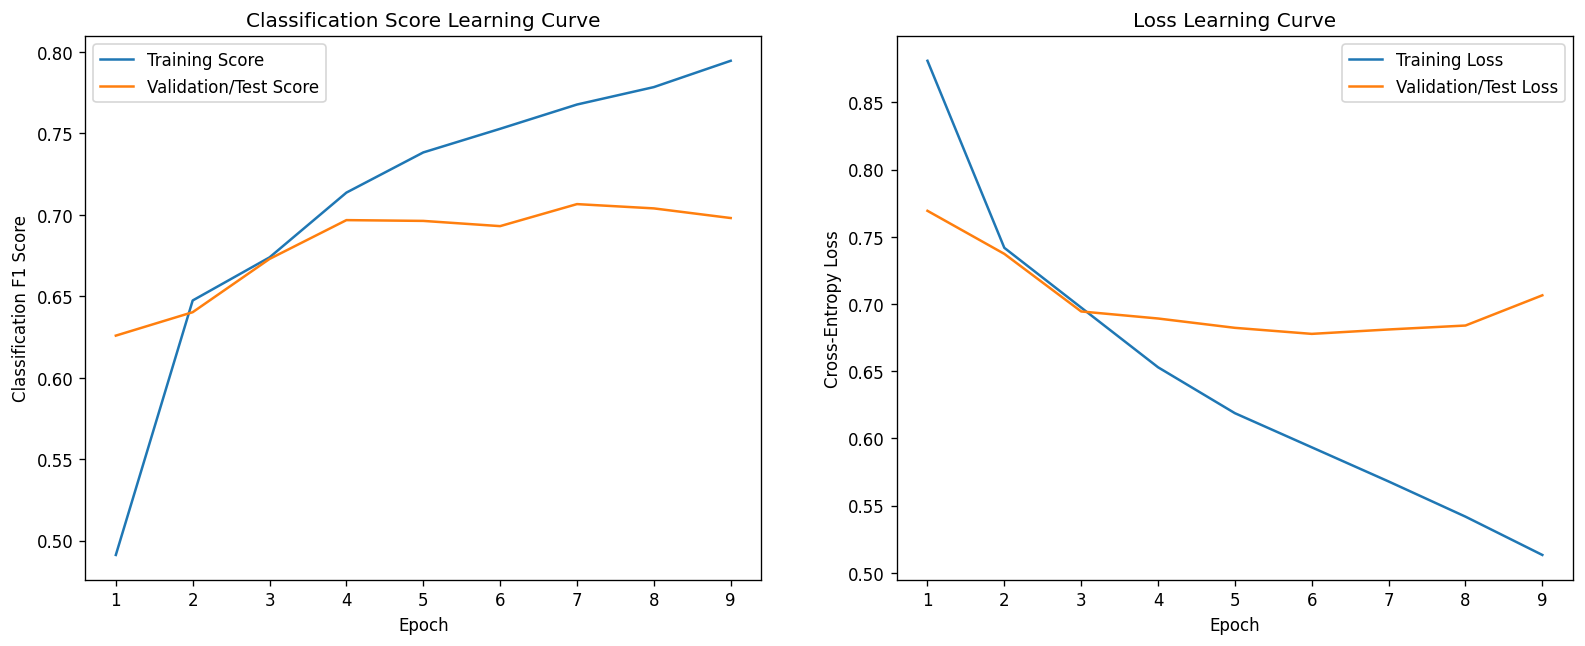

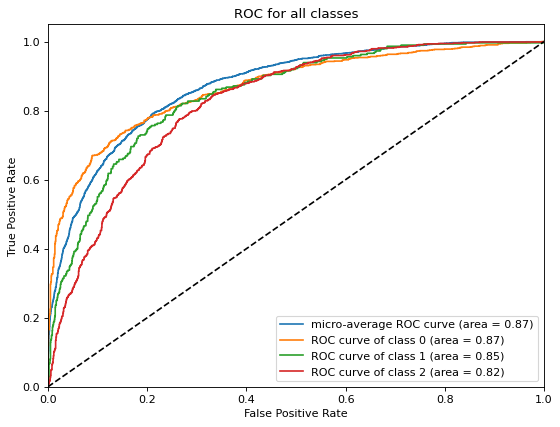

In [27]:
# hyperparameter tuning
num_hidden = 50     # number of features for each hidden cell
num_layers = 1      # number of stacked RNN layers
dropout_rate = 0.5  # dropout probability for regularization

model = Classifier('GRU', number_of_words, vector_size, embeddings_array, num_hidden , num_classes, num_layers, dropout_rate) 
#print(model)

# more hyperparamenter tuning
batch_size = 64
num_epochs = 10
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

# call training function for model, train for given num_epochs epochs
train_losses, val_losses, train_scores, val_scores, epochs, model = execute_training(model, loss_func, optimizer, batch_size, num_epochs)

# print model results
model_results(model, x_train, y_train, x_val, y_val, epochs, train_scores, val_scores, train_losses, val_losses)

## Tuning and Adding layer LSTM

Epoch 1/20 -- Train Loss: 1.0385 -- Validation Loss: 0.9784
Epoch 2/20 -- Train Loss: 0.9607 -- Validation Loss: 0.8997
Epoch 3/20 -- Train Loss: 0.8586 -- Validation Loss: 0.8187
Epoch 4/20 -- Train Loss: 0.8062 -- Validation Loss: 0.7867
Epoch 5/20 -- Train Loss: 0.7827 -- Validation Loss: 0.7725
Epoch 6/20 -- Train Loss: 0.7689 -- Validation Loss: 0.7681
Epoch 7/20 -- Train Loss: 0.7576 -- Validation Loss: 0.7620
Epoch 8/20 -- Train Loss: 0.7480 -- Validation Loss: 0.7562
Epoch 9/20 -- Train Loss: 0.7413 -- Validation Loss: 0.7560
Epoch 10/20 -- Train Loss: 0.7327 -- Validation Loss: 0.7551
Epoch 11/20 -- Train Loss: 0.7279 -- Validation Loss: 0.7469
Epoch 12/20 -- Train Loss: 0.7198 -- Validation Loss: 0.7480
Epoch 13/20 -- Train Loss: 0.7141 -- Validation Loss: 0.7423
Epoch 14/20 -- Train Loss: 0.7073 -- Validation Loss: 0.7499
Epoch 15/20 -- Train Loss: 0.7040 -- Validation Loss: 0.7470
Epoch 16/20 -- Train Loss: 0.6978 -- Validation Loss: 0.7421
Epoch 17/20 -- Train Loss: 0.6928

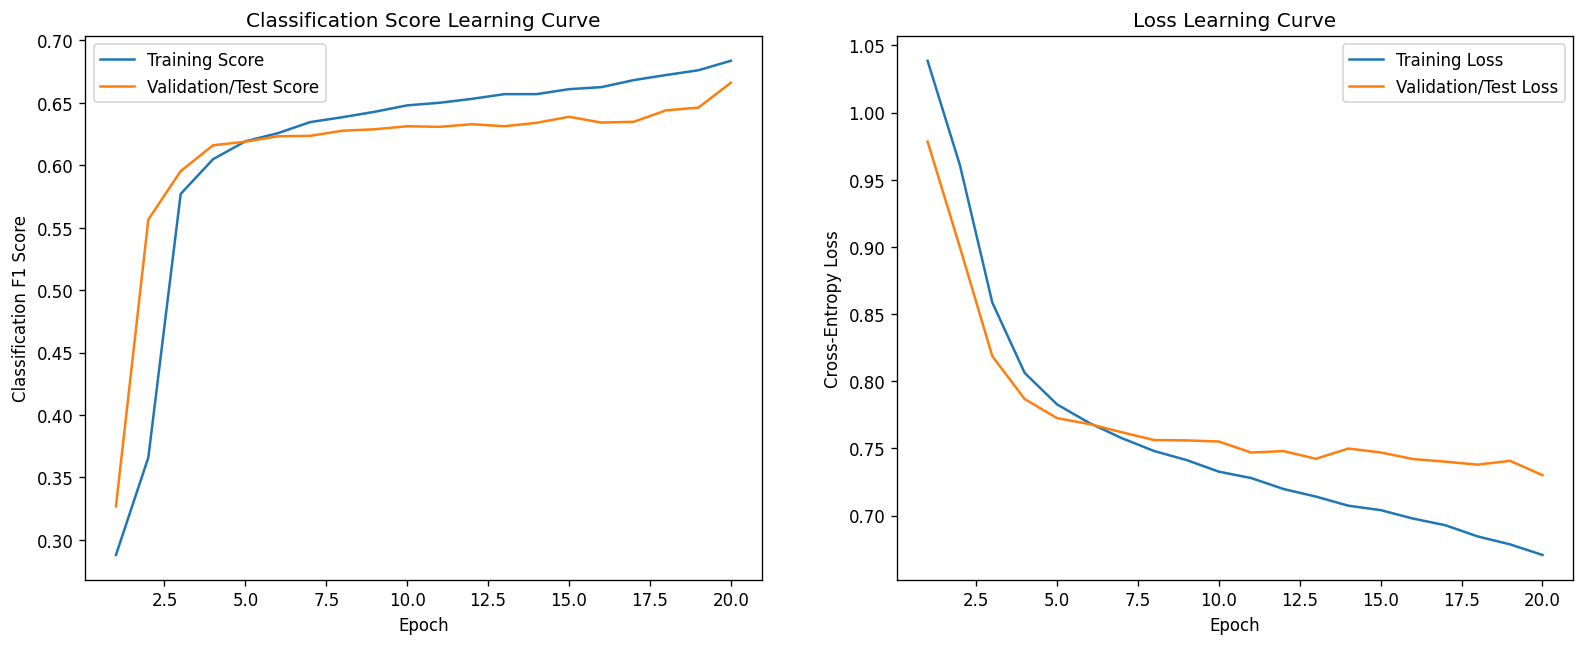

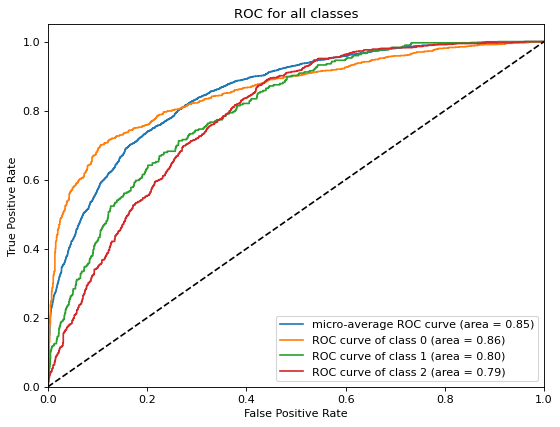

In [28]:
# hyperparameter tuning
num_hidden = 20     # number of features for each hidden cell
num_layers = 2      # number of stacked RNN layers
dropout_rate = 0.5  # dropout probability for regularization

model = Classifier('LSTM', number_of_words, vector_size, embeddings_array, num_hidden , num_classes, num_layers, dropout_rate) 
#print(model)

# more hyperparamenter tuning
batch_size = 64
num_epochs = 20
learning_rate = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

# call training function for model, train for given num_epochs epochs
train_losses, val_losses, train_scores, val_scores, epochs, model = execute_training(model, loss_func, optimizer, batch_size, num_epochs)

# print model results
model_results(model, x_train, y_train, x_val, y_val, epochs, train_scores, val_scores, train_losses, val_losses)

##Tuning and Adding layer GRU

Epoch 1/20 -- Train Loss: 1.0172 -- Validation Loss: 0.9808
Epoch 2/20 -- Train Loss: 0.9782 -- Validation Loss: 0.9699
Epoch 3/20 -- Train Loss: 0.8904 -- Validation Loss: 0.7952
Epoch 4/20 -- Train Loss: 0.7771 -- Validation Loss: 0.7706
Epoch 5/20 -- Train Loss: 0.7542 -- Validation Loss: 0.7571
Epoch 6/20 -- Train Loss: 0.7402 -- Validation Loss: 0.7473
Epoch 7/20 -- Train Loss: 0.7284 -- Validation Loss: 0.7401
Epoch 8/20 -- Train Loss: 0.7183 -- Validation Loss: 0.7334
Epoch 9/20 -- Train Loss: 0.7077 -- Validation Loss: 0.7389
Epoch 10/20 -- Train Loss: 0.6968 -- Validation Loss: 0.7267
Epoch 11/20 -- Train Loss: 0.6868 -- Validation Loss: 0.7218
Epoch 12/20 -- Train Loss: 0.6768 -- Validation Loss: 0.7133
Epoch 13/20 -- Train Loss: 0.6674 -- Validation Loss: 0.7110
Epoch 14/20 -- Train Loss: 0.6596 -- Validation Loss: 0.7078
Epoch 15/20 -- Train Loss: 0.6516 -- Validation Loss: 0.7063
Epoch 16/20 -- Train Loss: 0.6444 -- Validation Loss: 0.7058
Epoch 17/20 -- Train Loss: 0.6362

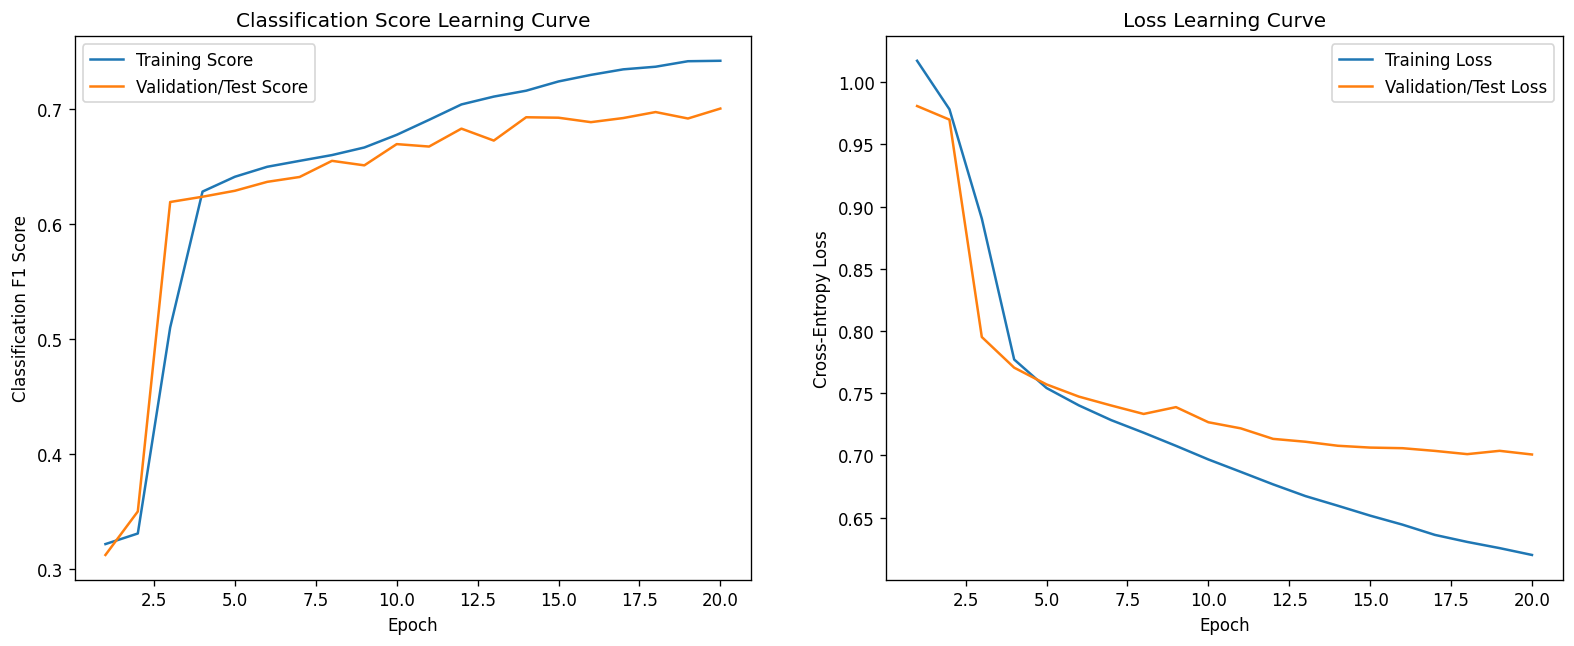

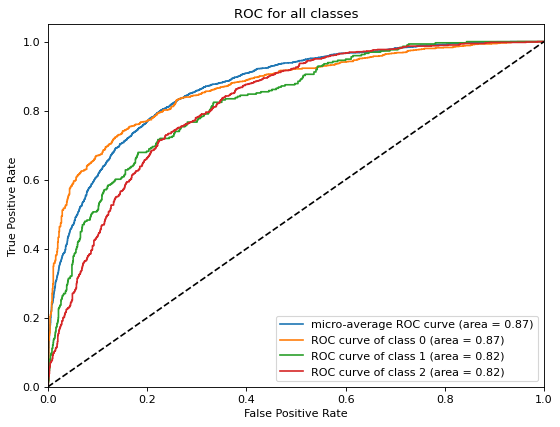

In [29]:
# hyperparameter tuning
num_hidden = 20     # number of features for each hidden cell
num_layers = 2      # number of stacked RNN layers
dropout_rate = 0.5  # dropout probability for regularization

model = Classifier('GRU', number_of_words, vector_size, embeddings_array, num_hidden , num_classes, num_layers, dropout_rate) 
#print(model)

# more hyperparamenter tuning
batch_size = 64
num_epochs = 20
learning_rate = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

# call training function for model, train for given num_epochs epochs
train_losses, val_losses, train_scores, val_scores, epochs, model = execute_training(model, loss_func, optimizer, batch_size, num_epochs)

# print model results
model_results(model, x_train, y_train, x_val, y_val, epochs, train_scores, val_scores, train_losses, val_losses)

## Adding skip connections

In [30]:
class SkipClassifier(nn.Module):
  """ Wrapper class for the classifier to be developed using LSTMs/GRUs and skip connections"""
  # dictionary for the type of cells to be used by classifier
  cells = {"LSTM" : nn.LSTM, "GRU" : nn.GRU}
  
  def __init__(self, cell_type, num_embeddings, embeddings_dim, embeddings_array, num_hidden , num_classes, num_layers, dropout_rate):
    """ constructor """
    # call to superclass constructor
    super().__init__()
    # embedding layer as input layer
    self.embedding = nn.Embedding(num_embeddings, embeddings_dim)
    self.embedding.weight = nn.Parameter(torch.tensor(embeddings_array, dtype=torch.float32))
    self.embedding.weight.requires_grad = False   # embeddings array weights are pre-trained from GloVe, so no training required
    # a stacked-bidirectional LSTM or GRU RNN follows
    self.layers = nn.ModuleList()
    for i in range(num_layers):
      input_size = embeddings_dim if i == 0 else 2 * num_hidden
      self.layers.append(SkipClassifier.cells[cell_type](input_size, num_hidden, 1, bias=True, batch_first=True, dropout=dropout_rate, bidirectional=True))
    # output layer
    self.out = nn.Linear(2*num_hidden, num_classes)   # need 2 * num_hidden because it's bidirectional
    self.dropout = nn.Dropout(dropout_rate)
    self.num_layers = num_layers
    self.cell_type = cell_type

  def forward(self, x):
    """ performs a forward pass through model on input x, returns output """
    """ x must be a tensor of shape : (batch_size, sequence_length, input_size) """
    # input x first passes through the embedding layer : before x has shape (batch_size, sequence_length) after has shape (batch_size, sequence_length, embeddings_dim) which is the shape of x desired
    x = self.embedding(x)
    # embedded x becomes input to the first lstm/gru layer
    input = x
    if self.cell_type == 'LSTM':
      output, (hn, cn) = self.layers[0](input)  #output is a tensor of shape (batch_size, sequence_length, 2 * num_hidden)
    else:
      output, hn = self.layers[0](input)
    # output of first lstm/gru layer becomes input to second lstm/gru layer
    input = output
    # continuing for the rest lstm/gru layers, using skip connections (skip blocks)
    for i in range(1, self.num_layers):
      if (i % 2 == 1):
        identity = input
      if self.cell_type == 'LSTM':
        output, (hn, cn) = self.layers[i](input)  #output is a tensor of shape (batch_size, sequence_length, 2 * num_hidden)
      else:
        output, hn = self.layers[i](input)
      if (i % 2 == 0):
        output += identity
      input = output
      
    # output passes through the final linear output layer, to produce raw scores for each class
    output = self.out(output[:, -1, :]) #get output from the last (rightmost) timestep/hidden state
    # return raw scores for each class
    return output



## Using a deeper network with skip connections

Epoch 1/20 -- Train Loss: 0.9938 -- Validation Loss: 0.9776
Epoch 2/20 -- Train Loss: 0.9308 -- Validation Loss: 0.8058
Epoch 3/20 -- Train Loss: 0.7790 -- Validation Loss: 0.7590
Epoch 4/20 -- Train Loss: 0.7446 -- Validation Loss: 0.7444
Epoch 5/20 -- Train Loss: 0.7233 -- Validation Loss: 0.7323
Epoch 6/20 -- Train Loss: 0.7086 -- Validation Loss: 0.7195
Epoch 7/20 -- Train Loss: 0.6923 -- Validation Loss: 0.7091
Epoch 8/20 -- Train Loss: 0.6754 -- Validation Loss: 0.7024
Epoch 9/20 -- Train Loss: 0.6612 -- Validation Loss: 0.6942
Epoch 10/20 -- Train Loss: 0.6500 -- Validation Loss: 0.6924
Epoch 11/20 -- Train Loss: 0.6391 -- Validation Loss: 0.6855
Epoch 12/20 -- Train Loss: 0.6305 -- Validation Loss: 0.6933
Epoch 13/20 -- Train Loss: 0.6198 -- Validation Loss: 0.6890
Epoch 14/20 -- Train Loss: 0.6120 -- Validation Loss: 0.6817
Epoch 15/20 -- Train Loss: 0.6012 -- Validation Loss: 0.6856
Epoch 16/20 -- Train Loss: 0.5929 -- Validation Loss: 0.6948
Epoch 17/20 -- Train Loss: 0.5851

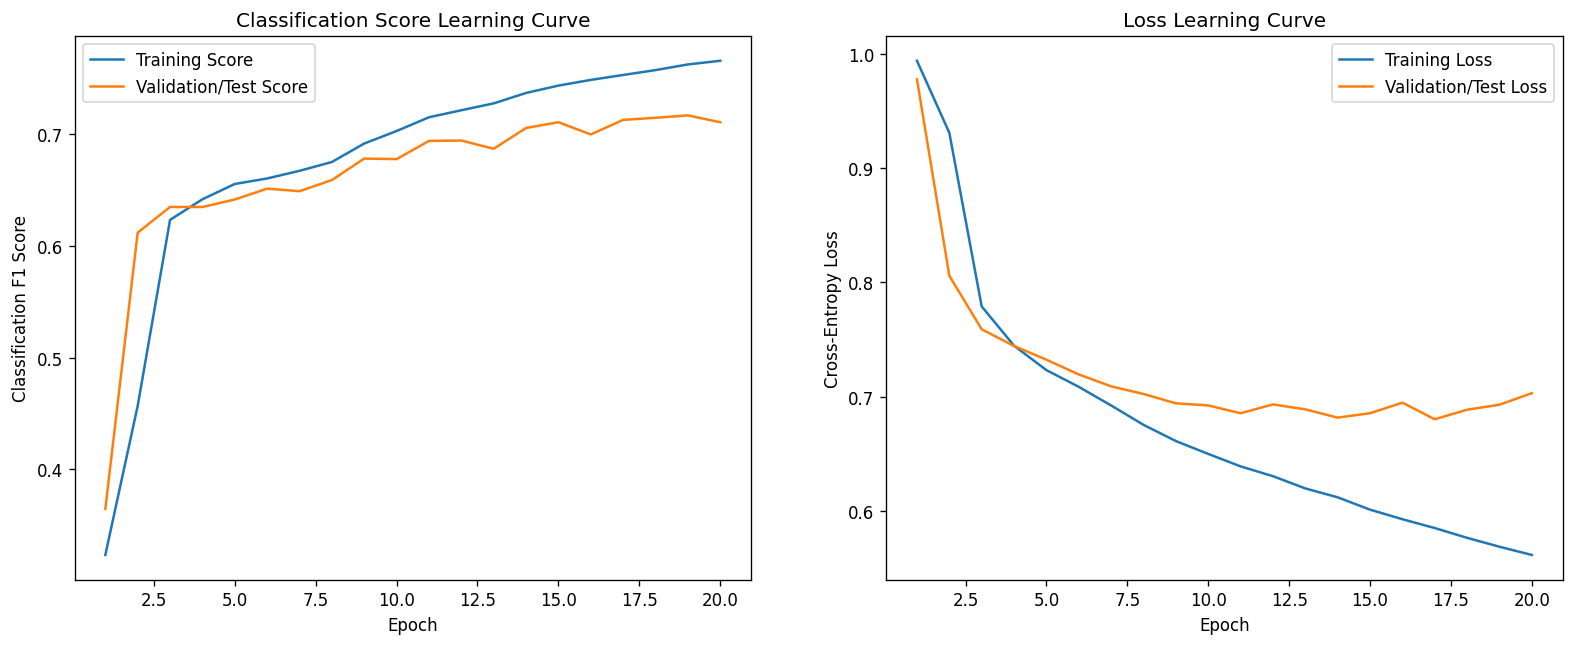

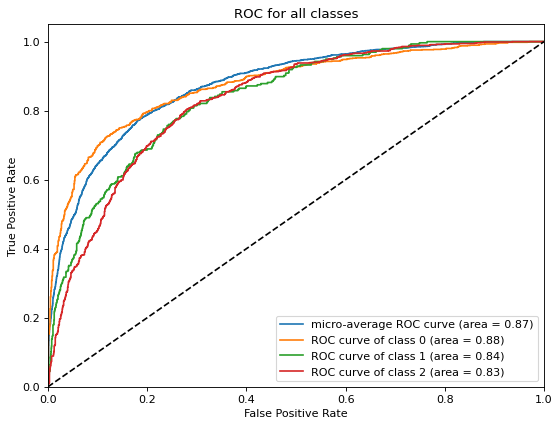

In [31]:
# hyperparameter tuning
num_hidden = 20     # number of features for each hidden cell
num_layers = 5      # number of stacked RNN layers
dropout_rate = 0.5  # dropout probability for regularization

model = SkipClassifier('GRU', number_of_words, vector_size, embeddings_array, num_hidden , num_classes, num_layers, dropout_rate) 
#print(model)

# more hyperparamenter tuning
batch_size = 64
num_epochs = 20
learning_rate = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

# call training function for model, train for given num_epochs epochs
train_losses, val_losses, train_scores, val_scores, epochs, model = execute_training(model, loss_func, optimizer, batch_size, num_epochs)

# print model results
model_results(model, x_train, y_train, x_val, y_val, epochs, train_scores, val_scores, train_losses, val_losses)

##Adding Attention to best model

In [32]:
class AttentionClassifier(nn.Module):
  """ Wrapper class for the classifier to be developed using LSTMs/GRUs with Attention """
  # dictionary for the type of cells to be used by classifier
  cells = {"LSTM" : nn.LSTM, "GRU" : nn.GRU}
  
  def __init__(self, cell_type, num_embeddings, embeddings_dim, embeddings_array, num_hidden , num_classes, num_layers, dropout_rate):
    """ constructor """
    # call to superclass constructor
    super().__init__()
    # embedding layer as input layer
    self.embedding = nn.Embedding(num_embeddings, embeddings_dim)
    self.embedding.weight = nn.Parameter(torch.tensor(embeddings_array, dtype=torch.float32))
    self.embedding.weight.requires_grad = False   # embeddings array weights are pre-trained from GloVe, so no training required
    # a stacked-bidirectional LSTM or GRU RNN follows 
    self.cell = AttentionClassifier.cells[cell_type](embeddings_dim, num_hidden, num_layers, bias=True, batch_first=True, dropout=dropout_rate, bidirectional=True)
    # attention layer
    self.attention = nn.Linear(2*num_hidden, 1, bias=True)
    # attention layer activation
    self.tanh = nn.Tanh()
    # softmax layer
    self.softmax = nn.Softmax(dim=1)
    # output layer
    self.out = nn.Linear(2*num_hidden, num_classes)   # need 2 * num_hidden because it's bidirectional
    self.dropout = nn.Dropout(dropout_rate)
    self.num_layers = num_layers
    self.cell_type = cell_type

  def forward(self, x):
    """ performs a forward pass through model on input x, returns output """
    """ x must be a tensor of shape : (batch_size, sequence_length, input_size) """
    # input x first passes through the embedding layer : before x has shape (batch_size, sequence_length) after has shape (batch_size, sequence_length, embeddings_dim) which is the shape of x desired
    x = self.embedding(x)
    # embedded x then passes through the stacked-bidirectional LSTM/GRU
    if self.cell_type == 'LSTM':
      output, (hn, cn) = self.cell(x)  #output is a tensor of shape (batch_size, sequence_length, 2 * num_hidden)
    else:
      output, hn = self.cell(x)
    #output is a tensor of shape (batch_size, sequence_length, 2 * num_hidden)
    #output passes through attention layer, and activation of attention layer
    attention_weights = self.tanh(self.attention(output))
    attention_weights = self.softmax(attention_weights)
    output = output * attention_weights
    output = torch.sum(output, dim=1)

    # output passes through the final linear output layer, to produce raw scores for each class
    output = self.out(output)
    # return raw scores for each class
    return output



Epoch 1/20 -- Train Loss: 0.9537 -- Validation Loss: 0.8263
Epoch 2/20 -- Train Loss: 0.7797 -- Validation Loss: 0.7453
Epoch 3/20 -- Train Loss: 0.7380 -- Validation Loss: 0.7213
Epoch 4/20 -- Train Loss: 0.7188 -- Validation Loss: 0.7098
Epoch 5/20 -- Train Loss: 0.7030 -- Validation Loss: 0.7003
Epoch 6/20 -- Train Loss: 0.6922 -- Validation Loss: 0.6970
Epoch 7/20 -- Train Loss: 0.6831 -- Validation Loss: 0.6915
Epoch 8/20 -- Train Loss: 0.6721 -- Validation Loss: 0.6907
Epoch 9/20 -- Train Loss: 0.6632 -- Validation Loss: 0.6874
Epoch 10/20 -- Train Loss: 0.6557 -- Validation Loss: 0.6862
Epoch 11/20 -- Train Loss: 0.6493 -- Validation Loss: 0.6820
Epoch 12/20 -- Train Loss: 0.6431 -- Validation Loss: 0.6826
Epoch 13/20 -- Train Loss: 0.6371 -- Validation Loss: 0.6836
Epoch 14/20 -- Train Loss: 0.6293 -- Validation Loss: 0.6846
Early Stopping

Classification scores for training set:

Weighted average Precision =  0.7448258670996477
Weighted average Recall    =  0.7438032048072108


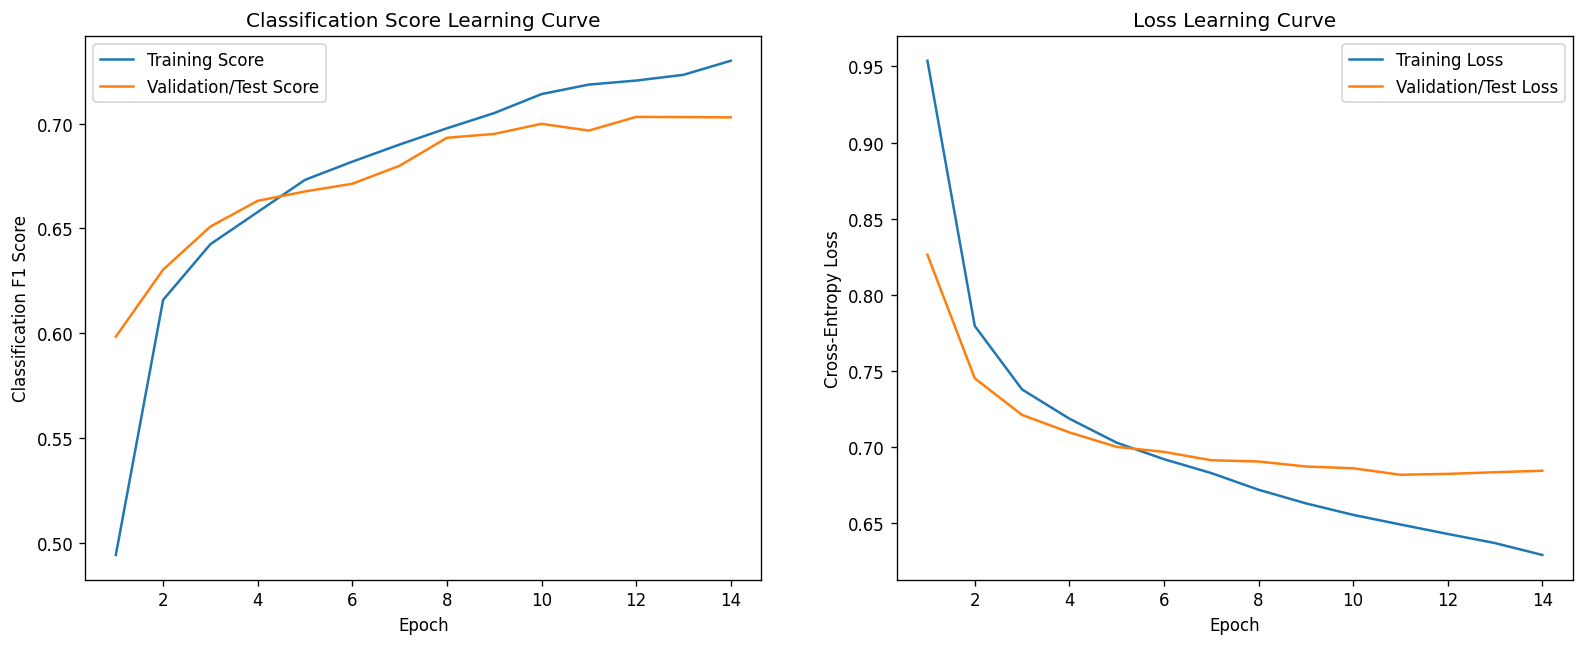

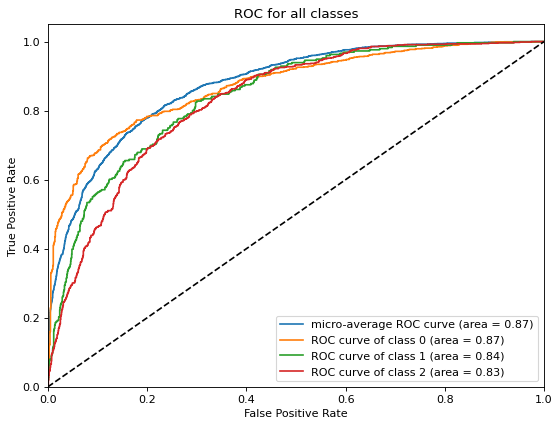

In [33]:
# hyperparameter tuning
num_hidden = 20     # number of features for each hidden cell
num_layers = 2      # number of stacked RNN layers
dropout_rate = 0.5  # dropout probability for regularization

model = AttentionClassifier('GRU', number_of_words, vector_size, embeddings_array, num_hidden , num_classes, num_layers, dropout_rate) 
#print(model)

# more hyperparamenter tuning
batch_size = 64
num_epochs = 20
learning_rate = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

# call training function for model, train for given num_epochs epochs
train_losses, val_losses, train_scores, val_scores, epochs, model = execute_training(model, loss_func, optimizer, batch_size, num_epochs)

# print model results
model_results(model, x_train, y_train, x_val, y_val, epochs, train_scores, val_scores, train_losses, val_losses)

## Final Model

Epoch 1/20 -- Train Loss: 1.0101 -- Validation Loss: 0.9161
Epoch 2/20 -- Train Loss: 0.8274 -- Validation Loss: 0.7641
Epoch 3/20 -- Train Loss: 0.7501 -- Validation Loss: 0.7369
Epoch 4/20 -- Train Loss: 0.7252 -- Validation Loss: 0.7187
Epoch 5/20 -- Train Loss: 0.7094 -- Validation Loss: 0.7087
Epoch 6/20 -- Train Loss: 0.6951 -- Validation Loss: 0.7017
Epoch 7/20 -- Train Loss: 0.6817 -- Validation Loss: 0.6993
Epoch 8/20 -- Train Loss: 0.6732 -- Validation Loss: 0.6944
Epoch 9/20 -- Train Loss: 0.6648 -- Validation Loss: 0.6902
Epoch 10/20 -- Train Loss: 0.6582 -- Validation Loss: 0.6878
Epoch 11/20 -- Train Loss: 0.6487 -- Validation Loss: 0.6852
Epoch 12/20 -- Train Loss: 0.6408 -- Validation Loss: 0.6873
Epoch 13/20 -- Train Loss: 0.6354 -- Validation Loss: 0.6810
Epoch 14/20 -- Train Loss: 0.6298 -- Validation Loss: 0.6802
Epoch 15/20 -- Train Loss: 0.6255 -- Validation Loss: 0.6797
Epoch 16/20 -- Train Loss: 0.6189 -- Validation Loss: 0.6834
Epoch 17/20 -- Train Loss: 0.6103

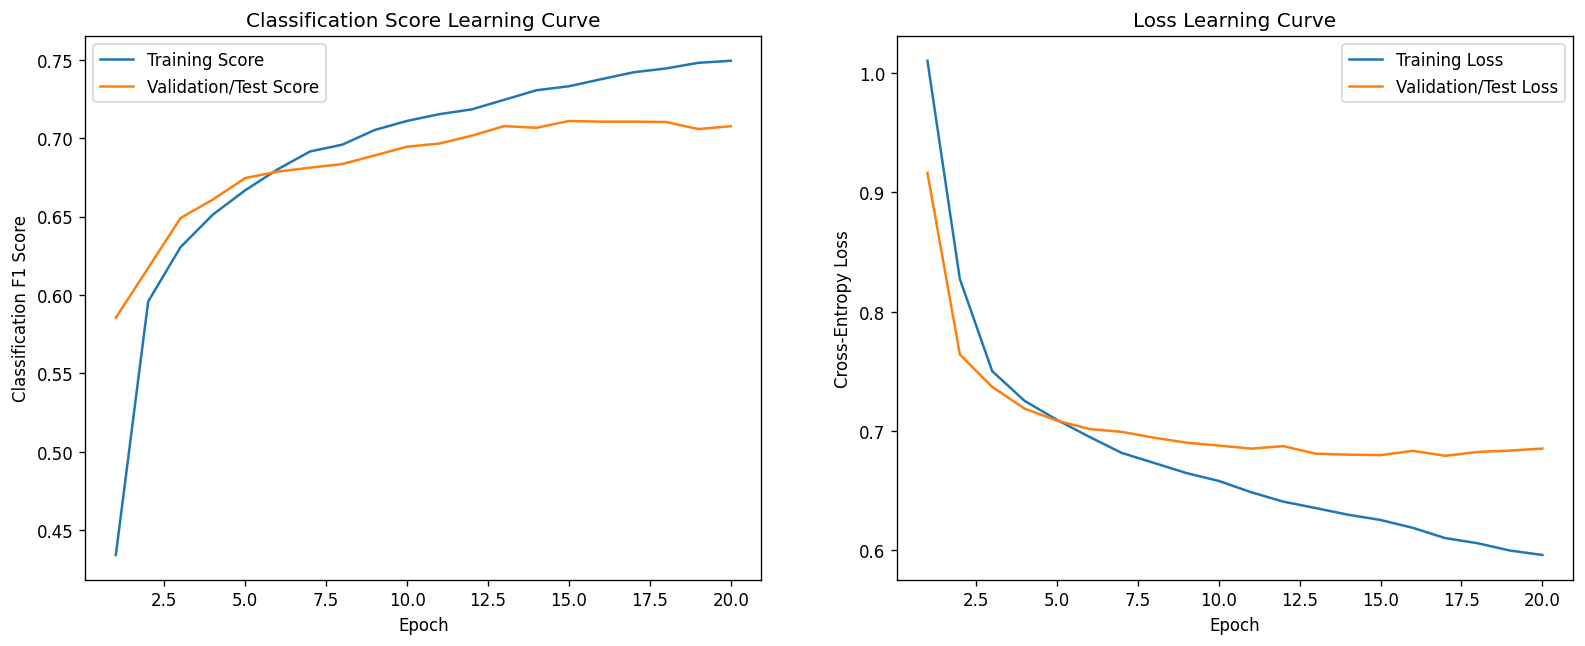

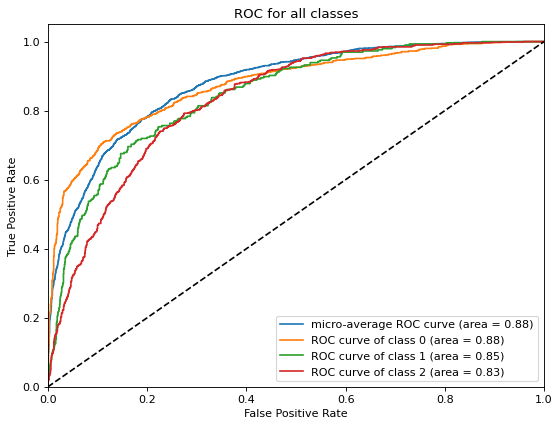

In [34]:
# choosing one of GloVe pre trained corpus
vector_size = 200
datafile = "glove.6B.200d.txt"
# dictionary with words of pre-trained corpus as keys, corresponding embeddings as values
word_vector_dict = {}
# one additional empty word embedding for padding / unknown words
word_vector_dict[''] = np.zeros(vector_size, dtype='float')
# reading .txt file with word embeddings
with open(datafile, 'r', encoding="utf-8") as File: 
  for row in File:
    tokenized_row = row.split()          # tokenize each row of file
    word = tokenized_row[0]              # first token of row corresponds to a word of corpus
    word_vector = np.array(tokenized_row[1:]).astype(np.float)  # rest of tokenized_row is the vector corresponding to given word
    word_vector_dict[word] = word_vector            # save word and its vector in word_vector dictionary

word_index_dict = {}
word_index = 0
number_of_words = len(word_vector_dict)
embeddings_array = np.zeros((number_of_words, vector_size))

for word in word_vector_dict:
  embeddings_array[word_index] = word_vector_dict[word]    # save word vector of word in embeddings array
  word_index_dict[word] = word_index  # save word in word_index dictionary
  word_index = word_index + 1

embeddings_array.shape

# MAIN FUNCTIONALITY

#Read the vaccine training set csv file
training_df = pd.read_csv("./sample_data/vaccine_train_set.csv")
#training_df.head()
#Read the vaccine validation set csv file
validation_df = pd.read_csv("./sample_data/vaccine_validation_set.csv")   # <------------- REPLACE TEST SET PATH HERE

cleaning = True   # TODO : EXPERIMENT WITH/WITHOUT DATA CLEANING

if cleaning:
  # apply text cleaning for the tweets as pre-processing for the training set
  training_df['tweet'] = training_df['tweet'].apply(data_cleaning)
  # apply text cleaning for the tweets as pre-processing for the validation set
  validation_df['tweet'] = validation_df['tweet'].apply(data_cleaning)

#Seperate tweet and label columns into seperate dataframes for the training set
train_tweet_df = pd.DataFrame(training_df, columns=[training_df.columns[1]])
train_label_df = pd.DataFrame(training_df, columns=[training_df.columns[-1]])
#Seperate tweet and label columns into seperate dataframes for the validation set
val_tweet_df = pd.DataFrame(validation_df, columns=[training_df.columns[1]])
val_label_df = pd.DataFrame(validation_df, columns=[training_df.columns[-1]])

train_sentences = [x for x in train_tweet_df['tweet']]
val_sentences = [x for x in val_tweet_df['tweet']]
num_classes = 3

# define a fixed length for the encoding of each sentence (maximum number of words of sentence)
max_length = 25  # if a sentence has more than 25 words, it gets padded, otherwise it gets truncated 
#Save in tensors
# for training set
x_train = sentences_to_sequences(train_sentences, word_index_dict, max_length)
y_train = torch.tensor(train_label_df.values, dtype=torch.long)
y_train = y_train.view(-1)
# for validation set
x_val = sentences_to_sequences(val_sentences, word_index_dict, max_length)
y_val = torch.tensor(val_label_df.values, dtype=torch.long)
y_val = y_val.view(-1)

class FinalClassifier(nn.Module):
  """ Wrapper class for the classifier to be developed using LSTMs/GRUs with Attention """
  # dictionary for the type of cells to be used by classifier
  cells = {"LSTM" : nn.LSTM, "GRU" : nn.GRU}
  
  def __init__(self, cell_type, num_embeddings, embeddings_dim, embeddings_array, num_hidden , num_classes, num_layers, dropout_rate):
    """ constructor """
    # call to superclass constructor
    super().__init__()
    # embedding layer as input layer
    self.embedding = nn.Embedding(num_embeddings, embeddings_dim)
    self.embedding.weight = nn.Parameter(torch.tensor(embeddings_array, dtype=torch.float32))
    self.embedding.weight.requires_grad = False   # embeddings array weights are pre-trained from GloVe, so no training required
    # a stacked-bidirectional LSTM or GRU RNN follows 
    self.cell = AttentionClassifier.cells[cell_type](embeddings_dim, num_hidden, num_layers, bias=True, batch_first=True, dropout=dropout_rate, bidirectional=True)
    # attention layer
    self.attention = nn.Linear(2*num_hidden, 1, bias=True)
    # attention layer activation
    self.tanh = nn.Tanh()
    # softmax layer
    self.softmax = nn.Softmax(dim=1)
    # output layer
    self.out = nn.Linear(2*num_hidden, num_classes)   # need 2 * num_hidden because it's bidirectional
    self.dropout = nn.Dropout(dropout_rate)
    self.num_layers = num_layers
    self.cell_type = cell_type

  def forward(self, x):
    """ performs a forward pass through model on input x, returns output """
    """ x must be a tensor of shape : (batch_size, sequence_length, input_size) """
    # input x first passes through the embedding layer : before x has shape (batch_size, sequence_length) after has shape (batch_size, sequence_length, embeddings_dim) which is the shape of x desired
    x = self.embedding(x)
    # embedded x then passes through the stacked-bidirectional LSTM/GRU
    if self.cell_type == 'LSTM':
      output, (hn, cn) = self.cell(x)  #output is a tensor of shape (batch_size, sequence_length, 2 * num_hidden)
    else:
      output, hn = self.cell(x)
    #output is a tensor of shape (batch_size, sequence_length, 2 * num_hidden)
    #output passes through attention layer, and activation of attention layer
    attention_weights = self.tanh(self.attention(output))
    attention_weights = self.softmax(attention_weights)
    output = output * attention_weights
    output = torch.sum(output, dim=1)

    # output passes through the final linear output layer, to produce raw scores for each class
    output = self.out(output)
    # return raw scores for each class
    return output


# hyperparameter tuning
num_hidden = 20     # number of features for each hidden cell
num_layers = 2      # number of stacked RNN layers
dropout_rate = 0.5  # dropout probability for regularization

model = FinalClassifier('GRU', number_of_words, vector_size, embeddings_array, num_hidden , num_classes, num_layers, dropout_rate) 
#print(model)

# more hyperparamenter tuning
batch_size = 64
num_epochs = 20
learning_rate = 0.0002
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_func = nn.CrossEntropyLoss()

# call training function for model, train for given num_epochs epochs
train_losses, val_losses, train_scores, val_scores, epochs, model = execute_training(model, loss_func, optimizer, batch_size, num_epochs)

# print model results
model_results(model, x_train, y_train, x_val, y_val, epochs, train_scores, val_scores, train_losses, val_losses)